In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from fastai.vision import *
import fastai
import pydicom as dicom
from pydicom.filereader import read_dicomdir
from fast_dicom import *

In [8]:
PATH = Path("/home/vhl_ai/Data/MRI/DICOMS")

In [20]:
class ProcessDCM():
    def __init__(self, study_path, new_spacing=np.array([1.,1.,1.])):
        self.new_spacing = new_spacing if new_spacing is not None else None
        self.study_path = study_path
        
    def get_scan(self, slices, is_scan=True):
        if is_scan == True:
            scan, px_spacing = self.proc_scan_files((slices))
        else:
            scan, px_spacing = self.proc_scan_files((slices))
            scan = np.where(scan != np.max(scan), 0, scan)
        #scan will have to be transformed to match the original DICOM    
        return scan, px_spacing
    
    def proc_scan_files(self, slices):
        scan_files = (dicom.read_file(str(i)) for i in slices)
        scan_files = sorted(scan_files, key=lambda x: x.ImagePositionPatient[-1])
        
        #spacing information for conversion
        slice_dist = [abs(float(a.ImagePositionPatient[-1]) - float(b.ImagePositionPatient[-1])) for a,b in zip(scan_files[1:], scan_files[:-1])]
        slice_dist = max_agree(slice_dist)
        px_spacing = list(max_agree([tuple([float(i) for i in f.PixelSpacing]) for f in scan_files]))
        slice_dist, px_spacing
        
        #conversion should always be identity so this will almost always be redundant
        slope, intercept = map(float, [scan_files[0].RescaleSlope, scan_files[0].RescaleIntercept])
        stack = [(i.pixel_array * slope) + intercept for i in scan_files][::-1]
        slope, intercept, np.shape(stack)
    
        #remove extraneous slices with wrong dim
        max_dim = max_agree([i.shape for i in stack])
        stack = np.stack([i for i in stack if tuple(i.shape) == max_dim])
        return stack, np.array([slice_dist] + px_spacing[::-1])
    
class GetDCM():
    #Class for setting up mri scan and mask pathways to easily generate data
    def __init__(self, study_path):
        self.study_path = study_path
        
    def get_scan_names(self):
        #get list of all MRI scans in the dataset
        mri_scans = sorted([str(os.path.basename(i)) for i in (self.study_path).ls() if '.csv' not in str(i) ])
        return mri_scans
    
    def get_scan_mask(self):
        #retrieve all mri dicom slices from designated scan
        scan_list = self.get_scan_names()
        #this is currently set to pull the second scan for testing functionality
        #Change the way this funciton is handled so that it goes through each scan.
        scan_slices = sorted([i for i in Path(PATH / scan_list[2] / 'Raw').ls()])
        mask_slices = sorted([i for i in Path(PATH / scan_list[2] / 'Mask').ls()])
        return scan_slices, mask_slices
        


In [21]:
gdcm = GetDCM(PATH)

In [22]:
foo_scan, foo_mask = gdcm.get_scan_mask()

In [23]:
PDCM = ProcessDCM(PATH)

In [24]:
foo_scan, foo_ps = PDCM.get_scan(foo_scan)
foo_mask, foo_mask_ps = PDCM.get_scan(foo_mask, is_scan=False)

In [25]:
np.shape(foo_mask), foo_mask_ps

((160, 448, 448), array([1.249527, 0.435268, 0.435268]))

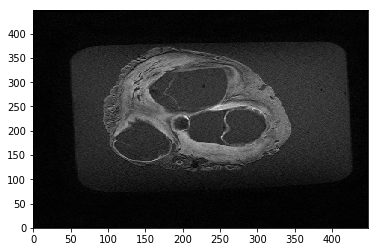

In [26]:
#Check how i need to transform this to match DICOM
plt.set_cmap(plt.gray())
plt.pcolormesh(np.flipud(foo_scan[73, :, :]))

In [27]:
np.max(foo_scan), np.min (foo_scan)

(2503.0, 0.0)

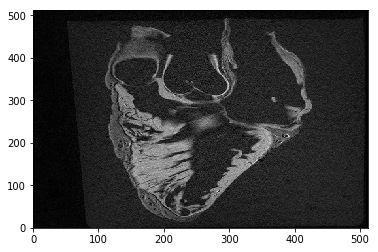

In [33]:
plt.set_cmap(plt.gray())
plt.pcolormesh(np.flip(foo_scan[60, :, :], [0,1]))

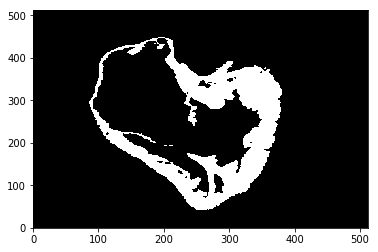

In [17]:
plt.set_cmap(plt.gray())
plt.pcolormesh(np.flipud(foo_mask[73, :, :]))

In [18]:
np.max(foo_mask)

2371.0

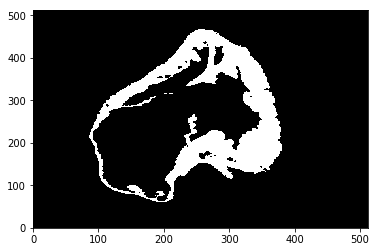

In [13]:
plt.set_cmap(plt.gray())
plt.pcolormesh((foo_mask[73, :, :]))